In [ ]:
# pip install tensorflow
# !pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
(X_train, y_train), (X_test, y_test)= keras.datasets.mnist.load_data()
print(len(X_train))
# Normalising input values
X_train= X_train / 255
X_test= X_test / 255

11493376/11490434 [==============================] - 0s 0us/step
60000


Input image is 


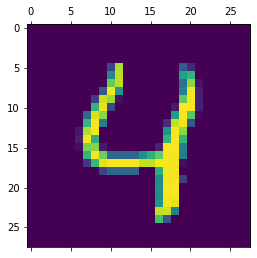

In [ ]:
X_test_single=X_test[4]#[4]
from matplotlib import pyplot as plt

print('Input image is ')
plt.matshow(X_test_single)

In [ ]:
X_train_flattened= X_train.reshape(len(X_train), 28*28)
X_test_flattened= X_test.reshape(len(X_test), 28*28)
X_test_single_flattened= X_test_single.reshape(1, 28*28)

In [ ]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.constraints import NonNeg , MinMaxNorm #NonNeg #max_norm

model= keras.Sequential([keras.layers.Dense(10, input_shape = (784,), activation ="sigmoid")])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

model.fit(X_train_flattened, y_train, epochs=5) #X is the input, Y is the label of input

Epoch 1/5
1875/1875 [==============================] - 6s 2ms/step - loss: 0.4715 - accuracy: 0.8756
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3037 - accuracy: 0.9151
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2838 - accuracy: 0.9202
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2731 - accuracy: 0.9240
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2666 - accuracy: 0.9256


In [ ]:
model.evaluate(X_test_flattened, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2664 - accuracy: 0.9261


[0.2663646936416626, 0.9261000156402588]

In [ ]:
y_predicted = model.predict(X_test_single_flattened)

print('The initial prediction of input digit is ' + str(np.argmax(y_predicted[0])))

The initial prediction of input digit is 4


# Finding layer weights and bias


In [ ]:
final_layer_weights = model.layers[0].get_weights()[0] #weights from hidden layer to output
final_layer_bias = model.layers[0].get_weights()[1] #weights from hidden layer to output


probabilities of predicted digits
[[8.6502722e-03 2.3418154e-07 3.1500150e-02 8.9525804e-03 6.7962646e-01
  6.1257356e-03 2.4847502e-03 7.2131717e-01 3.7315387e-01 9.9030030e-01]]
 
the target digit is 9


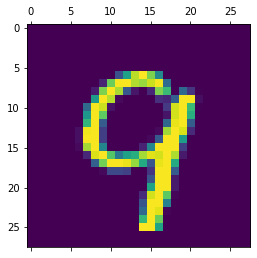

In [ ]:
# getting predicted values when image is of digit 9
X_test_single_CustomDigit=X_test[16]
plt.matshow(X_test_single_CustomDigit)

y_predicted_whenCustomDigit = model.predict(X_test_single_CustomDigit.reshape(1, 28*28)) # X_test_flattened has 10000 images so there are 10000 predictions
print('probabilities of predicted digits')
print(y_predicted_whenCustomDigit)
print(' ')
np.argmax(y_predicted_whenCustomDigit[0])

TargetDigitIndex = int(np.argmax(y_predicted_whenCustomDigit[0]))
print('the target digit is ' + str(TargetDigitIndex))

# Function for decomposing outputs to find new inputs

In [ ]:
def get_percentages(weights, bias, current_layer, layer_index, previous_layer):
    df = pd.DataFrame(columns = ['neuron_value', 'neuron_percentage'])
    distribution_neuron_id=TargetDigitIndex  # index of target digit.

    ''' setting goal output to output of custom digit. previously we were setting goal output by ourselves which possibly might be out of range. ''' 
    goalOutput = y_predicted_whenCustomDigit[0]
    new_values_combined=[]

    for hidden_neuron_index in range(len(current_layer)):
        df=df[0:0] #clearing df

        if layer_index == 0:
            if hidden_neuron_index!=distribution_neuron_id:
                continue

        for i in range(len(previous_layer)):
            df.loc[len(df)] = 0
            df.iloc[i]['neuron_value'] = (previous_layer[i] * weights[i][hidden_neuron_index]) + bias[hidden_neuron_index]

        Total = df['neuron_value'].sum()

        #Finding percentages to compute hidden layer values
        for i in range(len(previous_layer)):
            if(Total==0):
                df.iloc[i]['neuron_percentage'] = 0
            else:
                df.iloc[i]['neuron_percentage'] = df.iloc[i]['neuron_value'] / Total

        for i in range(len(previous_layer)):
            if layer_index == 0:
                #decomposition according to sigmoid function
                new_values_combined.append(previous_layer[i] - (((current_layer[hidden_neuron_index] - goalOutput[hidden_neuron_index]) * df.iloc[i]['neuron_percentage']) / (goalOutput[hidden_neuron_index] * (1 - goalOutput[hidden_neuron_index]) * weights[i][hidden_neuron_index])))

    if layer_index == 0:
        new_values=new_values_combined

    return df,new_values

    

# Finding new hidden layer values


In [ ]:
import pandas as pd

all_layers=[]
all_layers.append(y_predicted[0]) # Final Layer
all_layers.append(X_test_single_flattened[0]) # Inputs

for layer_index, layer_values in enumerate(all_layers):
    if layer_index == 0:
        df,new_final_inputs = get_percentages(final_layer_weights,final_layer_bias, layer_values, layer_index, all_layers[layer_index+1])
    else:
        break

In [ ]:
result=new_final_inputs # safe keeping variable

updated image after decomposition


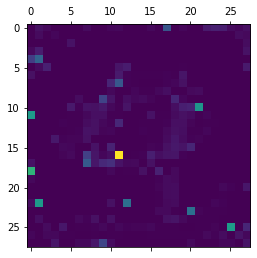

In [ ]:
new_final_inputs = result

pppp = [0 if i < 0 else i for i in new_final_inputs] # removing -ve values from new inputs
new_final_inputs= pppp

"""
converting new final inputs to image matrix and displaying the image
"""

arr = np.array(new_final_inputs)
shape = (28, 28)

plt.matshow(arr.reshape( shape ))
print('updated image after decomposition')

In [ ]:
"""
passing new final inputs through prediction algorithm and checking the results
"""
x = np.array(new_final_inputs)
new_final_inputs_flat= x.reshape(1, 28*28)

y_verify_decomposed = model.predict(new_final_inputs_flat)
print(y_verify_decomposed)
print('Prediction result image after decomposition')

print('the prediction of updated/decomposed image is ' + str(np.argmax(y_verify_decomposed)))

[[5.5832079e-05 3.7773108e-18 1.6888238e-04 2.3780955e-09 2.8175955e-06
  3.2511668e-08 1.1806716e-03 1.4512050e-04 7.6156152e-06 9.9994779e-01]]
Prediction result image after decomposition
the prediction of updated/decomposed image is 9
